<a href="https://colab.research.google.com/github/SwordForShinobi/Blur-clear-NN-detector/blob/main/CFT_deblurring_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning NN for CFT blur/clear task


# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from pathlib import Path
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Data preparation

In [ ]:
# Download data from kaggle

!kaggle competitions download -c shift-cv-winter-2023
!mkdir CFT_task
!unzip shift-cv-winter-2023 -d CFT_task

In [ ]:
import pandas as pd
df = pd.read_csv('CFT_task/train.csv')
df.head(5)

,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0


In [ ]:
list_of_blur = df[df['blur']==1]['filename'].values.tolist()
os.mkdir('CFT_task/train/blurred')

for i in list_of_blur:
  shutil.move('CFT_task/train/train/' + i, 'CFT_task/train/blurred/' + i)

os.rename('CFT_task/train/train/', 'CFT_task/train/clear/')

In [ ]:
train_dir = 'CFT_task/train'
test_dir = 'CFT_task/test/test'
BATCH_SIZE=32
IMG_SIZE = 640
INP_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
image_gen_train = ImageDataGenerator(validation_split=0.2,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest",
                                     )

train_generator = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SIZE,IMG_SIZE),
    directory=train_dir,
    class_mode='binary',
    subset='training',
    color_mode='rgb')

validation_generator = image_gen_train.flow_from_directory(
    train_dir, # same directory as training data
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='binary',
    subset='validation',
    color_mode='rgb')

Found 2132 images belonging to 2 classes.
Found 532 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'blurred': 0, 'clear': 1}

# NN building

In [ ]:
EPOCHS = 20

  
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=INP_SHAPE)
pretrained_model.trainable = False # обучение пока отключим
    
# добавим немного слоев...
model = tf.keras.Sequential([
  pretrained_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    
# метрика в соревновании AUC_ROC
auc_roc = tf.keras.metrics.AUC()
        
model.compile(
#     optimizer='adam',
    optimizer=tf.keras.optimizers.Nadam(),
    loss = 'binary_crossentropy',
    metrics=auc_roc
)

historical = model.fit(train_generator, 
          epochs=EPOCHS, 
          validation_data=validation_generator)

Epoch 1/20
67/67 [==============================] - 297s 4s/step - loss: 0.7262 - auc_1: 0.7157 - val_loss: 0.4700 - val_auc_1: 0.8627
Epoch 2/20
10/67 [===>..........................] - ETA: 2:48 - loss: 0.5139 - auc_1: 0.8369

KeyboardInterrupt: ignored

In [ ]:
    
pretrained_model.trainable = True # немного "расшатаем" модель (эмпирическое наблюдение - иногда очень помогает :)

model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss = 'binary_crossentropy',
    metrics=auc_roc)
    
EPOCHS = 3

historical = model.fit(train_generator, 
          epochs=EPOCHS, 
          validation_data=validation_generator)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(1e-5), # делаем fine-tuning с низким learning rate
    loss = 'binary_crossentropy',
    metrics=auc_roc)

EPOCHS = 10

historical = model.fit(train_generator, 
          epochs=EPOCHS, 
          validation_data=validation_generator)

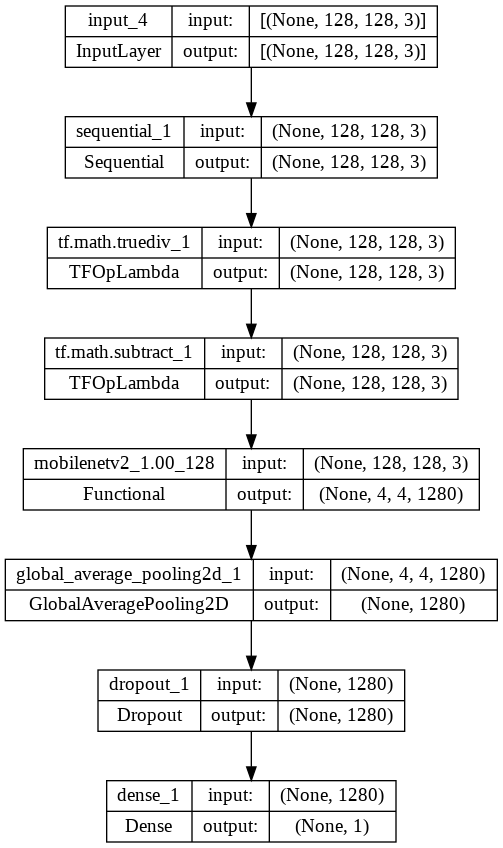

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
# adding real-time graph building and a checkpoint callbacks

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

checkpoint = tf.keras.callbacks.ModelCheckpoint('CFT_task/NN_checkpoint.h5',
                                                monitor='accuracy',
                                                verbose=1,
                                                save_best_only=True, mode='max')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# loading weights if NN wasn't changed

# model.load_weights('/content/drive/MyDrive/NN_CFT_blur_binary.h5')

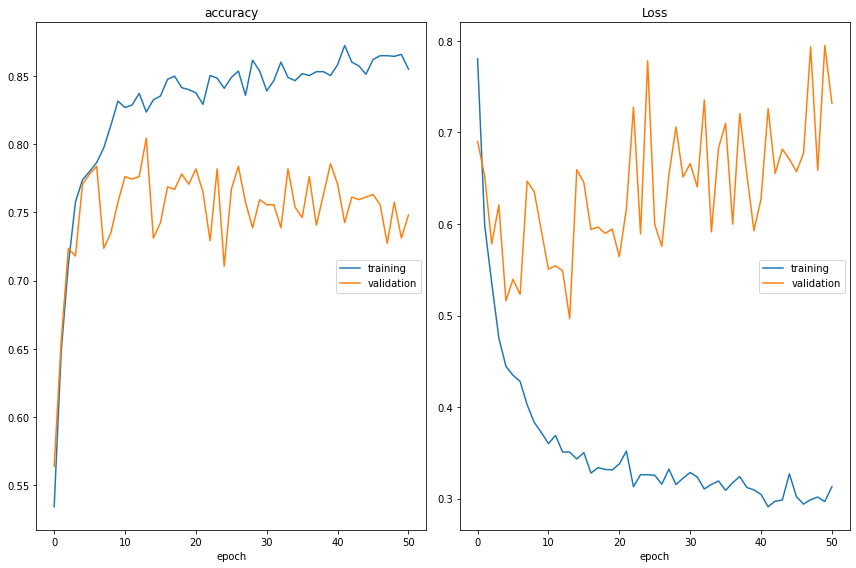

accuracy
	training         	 (min:    0.534, max:    0.872, cur:    0.855)
	validation       	 (min:    0.564, max:    0.805, cur:    0.748)
Loss
	training         	 (min:    0.291, max:    0.781, cur:    0.313)
	validation       	 (min:    0.497, max:    0.795, cur:    0.732)

Epoch 51: accuracy did not improve from 0.87242
34/34 [==============================] - 16s 464ms/step - loss: 0.3130 - accuracy: 0.8551 - val_loss: 0.7319 - val_accuracy: 0.7481
Epoch 52/75
19/34 [===============>..............] - ETA: 5s - loss: 0.2935 - accuracy: 0.8643

KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 75 #75
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

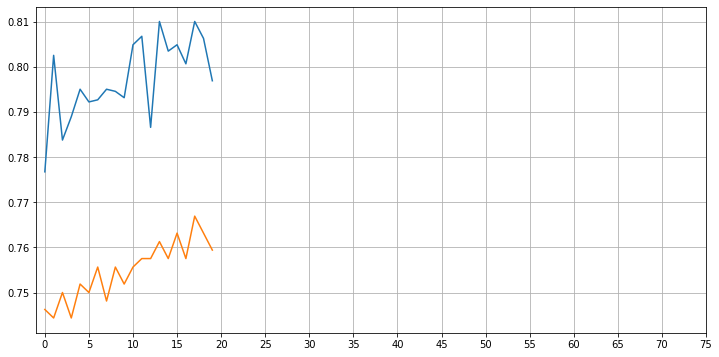

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, EPOCHS + 5, 5))
plt.grid(0.5)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NN_CFT_blur_binary.h5')

# Fine-tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Fine-tuning just in case

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
 model.evaluate(validation_generator)

9/9 [==============================] - 4s 320ms/step - loss: 0.7977 - accuracy: 0.7312


[0.7976803183555603, 0.731203019618988]

KeyboardInterrupt: ignored

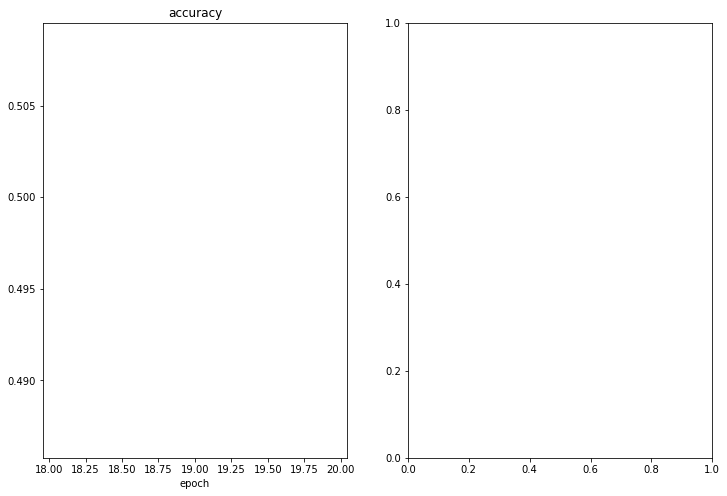

In [ ]:
fine_tune_epochs = 30

total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

# Inference

In [ ]:
# prepare picture for inference:
def prepare_to_inf(path):
  img = plt.imread(path)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy()[None, ...]
  return img

In [ ]:
# create function to predict test pictures:
path = 'CFT_task/test/test/'
def predict_picture(path):
  blur_or_not = []
  for i in os.listdir(path):
    s = model.predict(prepare_to_inf(path + i), workers=-1, verbose=0)
    blur_or_not.append(s)
  return blur_or_not # list of logits

In [ ]:
# making predictions (losgits)

predictions = predict_picture(path)
predictions = tf.nn.sigmoid(predictions) # activate logits

In [ ]:
# getting final submissions

submission = pd.read_csv('CFT_task/sample_submission.csv')
submission['filename'] = os.listdir(path)
submission['blur'] = [1 - i.numpy()[0][0] for i in predictions] # make final certanties of blurred pictures

submission.to_csv('//content/drive/MyDrive/CFT_task_submission.csv', sep=',', encoding='utf8', index=False)
submission.head(20)

,filename,blur
0,gkqkwktrwapavlknxmwl.jpg,0.995911
1,daexmalfngbkissdhpkz.jpg,0.926836
2,vkponkspdyoraaxfxvkf.jpg,0.815180
3,eaqxmtwjytssidisdfam.jpg,0.959067
4,imnbegdoeqztmlabsyfe.jpg,0.085304
5,ohrwiupqwajxfpsoorkp.jpg,0.029383
6,gapfyxdsjutjesqakqxo.jpg,0.305621
7,gomzvygffqiktnbdtyuu.jpg,0.594500
8,oylpywpwgobocnawyaed.jpg,0.061639
9,gquxunkuicmxdkmqhiji.jpg,0.860452
